In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('reviews.csv')
df.columns = ['ts', 'ds']

In [3]:
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})
df_example.index = pd.to_datetime(df_example.index)
df_example = df_example.sort_index(ascending = True)

Text(0.5, 1.0, 'ori')

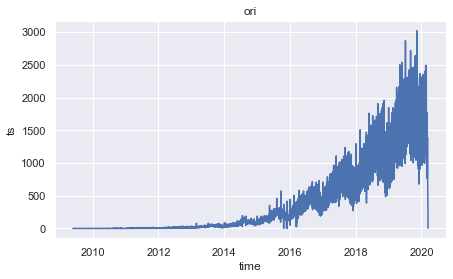

In [4]:
plt.figure(figsize = (7, 4))
plt.plot(df_example.ts)
plt.xlabel('time'); plt.ylabel('ts')
plt.title('ori')

In [5]:
df_example.head(2)

,ts
ds,
2009-05-26,1
2009-07-17,1


In [6]:
df_example.tail(2)

,ts
ds,
2020-03-13,275
2020-03-14,4


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    window = 12
    rolmean = df[ts].rolling(window = window, center = False).mean()
    rolstd  = df[ts].rolling(window = window, center = False).std()
    
    # Plot rolling statistics
    plt.figure(figsize = (7, 4))
    orig = plt.plot(df[ts],  color = 'b', label = 'Original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std  = plt.plot(rolstd,  color = 'g', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Std for Time Series')
    plt.show()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest   = adfuller(df[ts], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic',
                                               'p-value',
                                               '# Lags Used',
                                               '# of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value %s'%key] = value
    print(dfoutput)

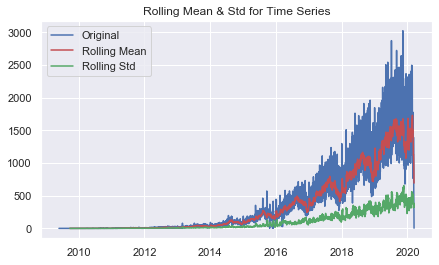

Results of Dickey-Fuller Test:
Test Statistic              -1.312983
p-value                      0.623212
# Lags Used                 30.000000
# of Observations Used    3554.000000
Critical Value 1%           -3.432191
Critical Value 5%           -2.862354
Critical Value 10%          -2.567203
dtype: float64


In [8]:
test_stationarity(df_example, 'ts')

**p value is very high, so ts is non-stationary**

In [9]:
df_example.head(2)

,ts
ds,
2009-05-26,1
2009-07-17,1


### Process
1. ts.diff()
2. ts.log
3. ts_log.diff()
4. ts_log_ewma_diff

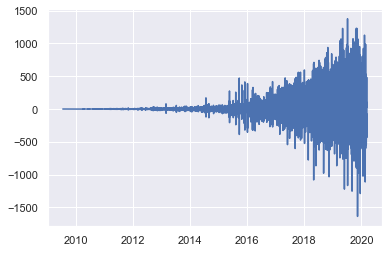

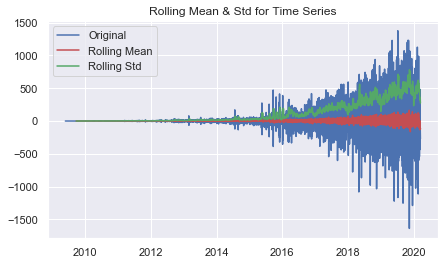

Results of Dickey-Fuller Test:
Test Statistic           -1.015008e+01
p-value                   7.994012e-18
# Lags Used               2.900000e+01
# of Observations Used    3.555000e+03
Critical Value 1%        -3.432191e+00
Critical Value 5%        -2.862353e+00
Critical Value 10%       -2.567203e+00
dtype: float64


In [10]:
df_example['ts_diff'] = df_example['ts'].diff()
plt.plot(df_example['ts_diff'])
test_stationarity(df_example.fillna(value = 0), 'ts_diff')

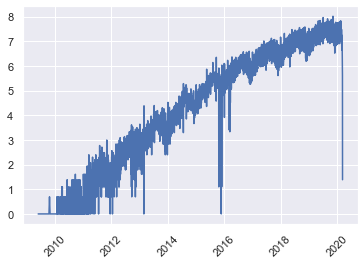

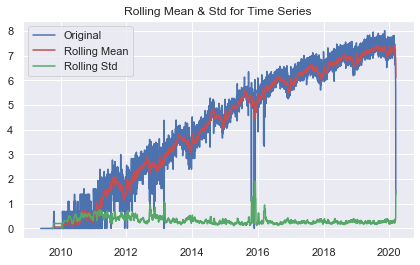

Results of Dickey-Fuller Test:
Test Statistic              -2.172223
p-value                      0.216481
# Lags Used                 30.000000
# of Observations Used    3554.000000
Critical Value 1%           -3.432191
Critical Value 5%           -2.862354
Critical Value 10%          -2.567203
dtype: float64


In [11]:
df_example['ts_log'] = np.log(df_example.ts)
fig = plt.plot(df_example.ts_log)
plt.xticks(rotation = 45)
test_stationarity(df_example, 'ts_log')

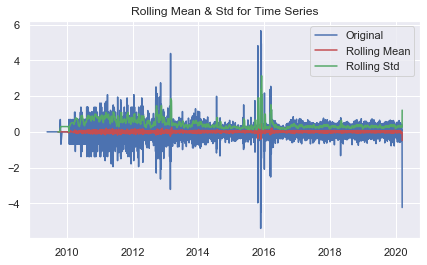

Results of Dickey-Fuller Test:
Test Statistic           -1.288002e+01
p-value                   4.680225e-24
# Lags Used               3.000000e+01
# of Observations Used    3.554000e+03
Critical Value 1%        -3.432191e+00
Critical Value 5%        -2.862354e+00
Critical Value 10%       -2.567203e+00
dtype: float64


In [12]:
df_example['ts_log_diff'] = df_example['ts_log'].diff()
test_stationarity(df_example.fillna(value = 0), 'ts_log_diff')

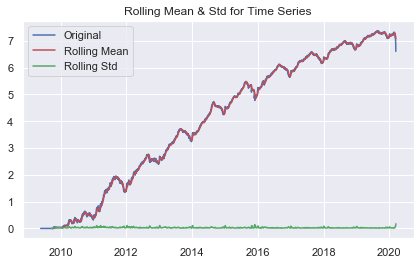

Results of Dickey-Fuller Test:
Test Statistic              -2.389990
p-value                      0.144582
# Lags Used                 28.000000
# of Observations Used    3556.000000
Critical Value 1%           -3.432190
Critical Value 5%           -2.862353
Critical Value 10%          -2.567203
dtype: float64


In [13]:
df_example['ts_log_ewma'] = df_example['ts_log'].ewm(halflife =12,\
                                                     ignore_na =False,
                                                     min_periods=0,
                                                     adjust=True).mean()
test_stationarity(df_example.fillna(value = 0), 'ts_log_ewma')

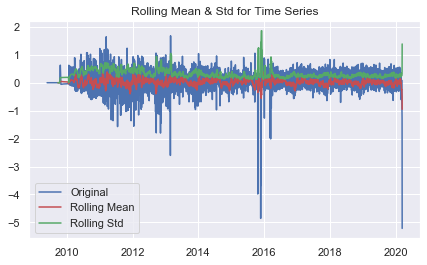

Results of Dickey-Fuller Test:
Test Statistic           -8.611068e+00
p-value                   6.473766e-14
# Lags Used               3.000000e+01
# of Observations Used    3.554000e+03
Critical Value 1%        -3.432191e+00
Critical Value 5%        -2.862354e+00
Critical Value 10%       -2.567203e+00
dtype: float64


In [14]:
df_example['ts_log_ewma_diff'] = df_example['ts_log'] - df_example['ts_log_ewma']
test_stationarity(df_example.fillna(value = 0), 'ts_log_ewma_diff')

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
def plot_decomposition(df, ts):
    
    decomposition = seasonal_decompose(df[ts], period = 365)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (14, 8), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(decomposition.trend, label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(decomposition.seasonal ,label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(decomposition.resid , label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

    #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
    plt.show()

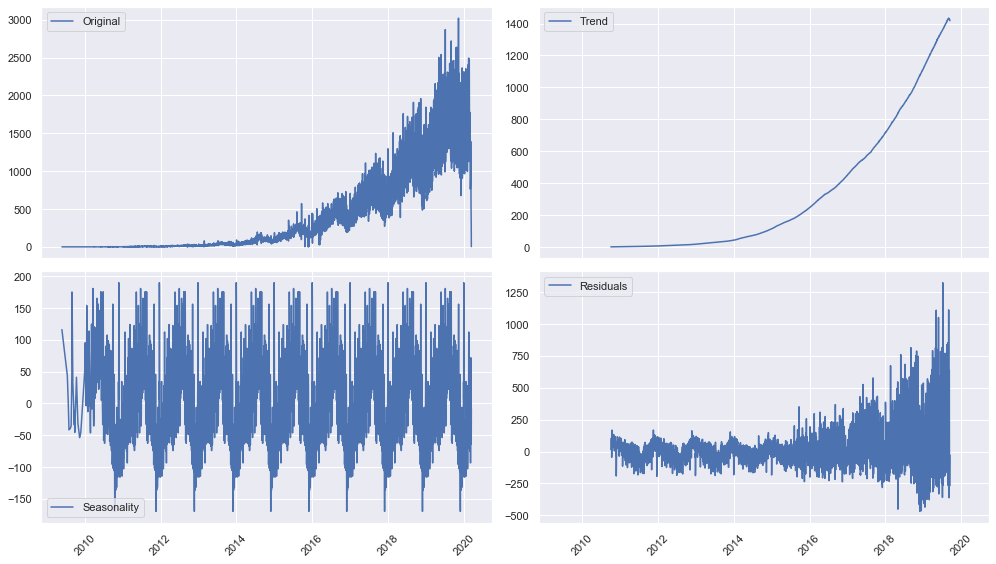

In [17]:
plot_decomposition(df_example, 'ts')

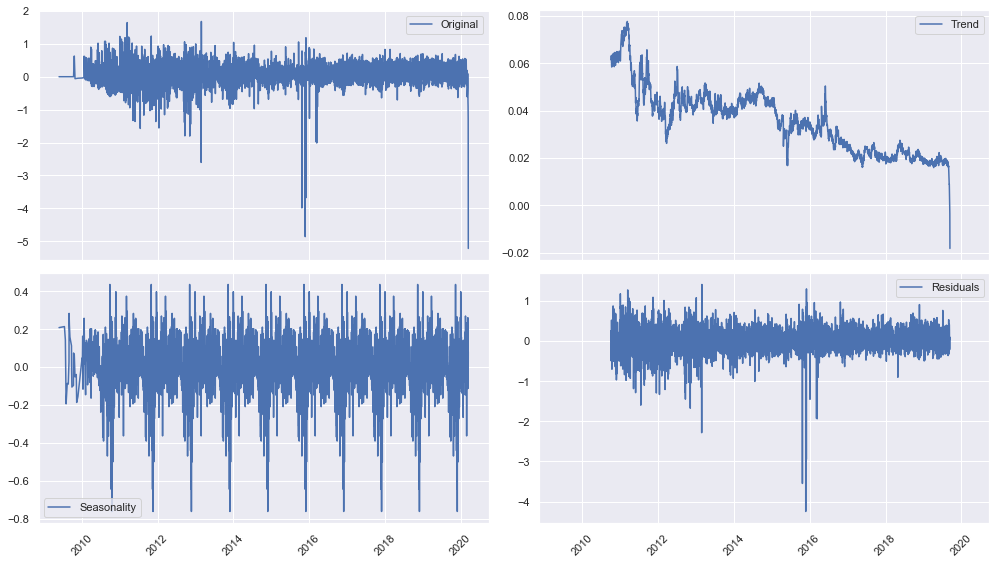

In [18]:
plot_decomposition(df_example, 'ts_log_ewma_diff')

In [19]:
df_example = df_example.fillna(value = 0)
from statsmodels.tsa.stattools import acf, pacf
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()

In [20]:
lag_acf = acf(np.array(df_example['ts_log_ewma_diff']),nlags=20)
lag_pacf = pacf(np.array(df_example['ts_log_ewma_diff']),nlags=20)

C:\Users\shuxg\AppData\Local\Continuum\anaconda3\envs\tensorflow-sessions\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


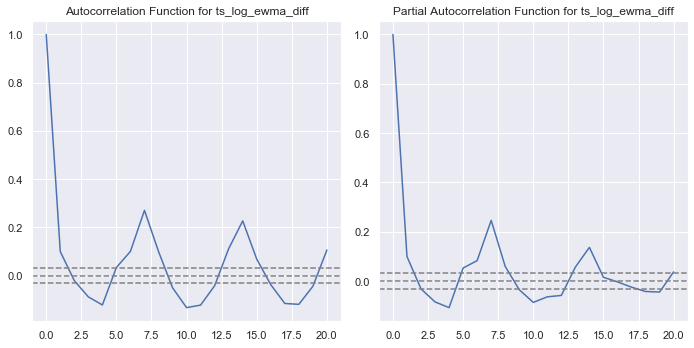

In [21]:
plot_acf_pacf(df = df_example, ts= 'ts_log_ewma_diff')

In [22]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\shuxg\AppData\Local\Continuum\anaconda3\envs\tensorflow-sessions\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\shuxg\AppData\Local\Continuum\anaconda3\envs\tensorflow-sessions\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


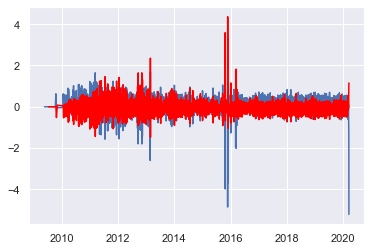

In [23]:
model = ARIMA(df_example['ts_log_ewma_diff'], order=(1, 1, 1))
results_arima=model.fit(disp=-1)

len_results = len(results_arima.fittedvalues)
ts_modified = df_example['ts_log_ewma_diff'][-len_results:]

rss  = sum((results_arima.fittedvalues - ts_modified)**2)
rmse = np.sqrt(rss/ len(df_example['ts_log_ewma_diff']))

plt.figure()
plt.plot(df_example['ts_log_ewma_diff'])
plt.plot(results_arima.fittedvalues, color='red')
plt.show()